# 0. Imports

### 0.1 Libs

In [203]:
import pickle
import requests
import json
import warnings

import psycopg2     as pg
import pandas       as pd
import numpy        as np
import seaborn      as sns
import scikitplot   as skplt

from IPython.display        import Image
from matplotlib             import pyplot           as plt
from scipy                  import stats            as ss
from sklearn                import preprocessing    as pp
from sklearn                import model_selection  as ms
from sklearn                import ensemble         as en
from sklearn                import neighbors        as nh
from sklearn                import linear_model     as lm
from lightgbm               import LGBMClassifier
  

# from sklearn.metrics import plot_lift_curve


### 0.2 Helper Functions

In [204]:
warnings.simplefilter("ignore")

# Cramér's V
def cramer_v(x,y):

    #Função para definir a correlação entre variáveis categóricas.

    # É feita utilizando o metodo "Cramér's V", onde:
        #v = np.sqrt ( (chi2/n) / (min(k-1, r-1)) )
            # Chi2 deriva do teste estatístico de Pearson 
            # n é o número de amostras
            #'K-1' é o número de colunas menos 1 e 'r-1' é o número de linhas -1

    # Diferente da correlação de Pearson para variáveis numéricas, que vai de '-1 a 1', o Cramér's V vai de '0 a 1' 


    cm = pd.crosstab( x, y).values               # Confusion Matrix (cm) - tabela de contingência
    n = cm.sum()                                 # n é o número de amortras
    r, k = cm.shape                              #'K' é o número de colunas e 'r' é o número de linhas
    chi2 = ss.chi2_contingency(cm)[0]
        # Linha 0: resultado do teste de chi2
        # Linha 1: resultado do p-valor
        # Linha 2: número de graus de liberdade
        # Linha 3: tabela de frequência

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )


# "At K" Metrics

def concat_order_data( x_val, y_val, yhat ):
    
    # copy data
    data = x_val.copy()
    data['response'] = y_val.copy()

    # propensity score
    data['score'] = yhat[:, 1].tolist()

    # sorted clients by propensity score
    data = data.sort_values( 'score', ascending=False )
    
    return data


def precision_at_k (data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k'] 

def recall_at_k (data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 

def at_k_metrics( model_name, x_val, y_val, yhat, k=20000 ):
    data = concat_order_data( x_val, y_val, yhat )
    
    pr = precision_at_k( data, k )
    re = recall_at_k( data, k )
    
    return pd.DataFrame({"Precision_at_k": "{}".format(np.round(pr,3)),
                         "Recall_at_k": "{}".format(np.round(re,3))}, index=[model_name])


# Cross Validation
def cross_validation(model_name, model, x_train, y_train, k=20000 ):
    
    precision_at_k_list = []
    recall_at_k_list = []

    skf = ms.StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    
    for train_index, test_index in skf.split(x_train, y_train):
        
        x_train_cv = x_train.iloc[train_index]
        y_train_cv = y_train.iloc[train_index]
        
        x_test_cv = x_train.iloc[test_index]
        y_test_cv = y_train.iloc[test_index]
        
        # model training
        model.fit(x_train_cv, y_train_cv)
        
        # prediction
        pred = model.predict_proba(x_test_cv)
        
        # concat
        data = x_test_cv.copy()
        data['response'] = y_test_cv.copy()
        
        data['score'] = pred[:, 1].tolist()
        
        data = data.sort_values( 'score', ascending=False )
        
        # measuring at k metrics
        precision_at_k_list.append( precision_at_k( data, k ) )
        recall_at_k_list.append(recall_at_k( data, k ) )
        
    
    precision_at_k_mean, precision_at_k_std     = np.round( np.mean( precision_at_k_list ), 2 ), np.round( np.std( precision_at_k_list ), 2 )
    recall_at_k_mean, recall_at_k_std           = np.round( np.mean( recall_at_k_list ), 2 ), np.round( np.std( recall_at_k_list ), 2 )
   
    
    return pd.DataFrame({"CV_Precision_at_k": "{} +/- {}".format(precision_at_k_mean, precision_at_k_std),
                         "CV_Recall_at_k": "{} +/- {}".format(recall_at_k_mean, recall_at_k_std)}, index=[model_name])

### 0.3 Loading data

In [205]:
# # Credentials to access SQL Database:

# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = 'member'
# pwd = 'cdspa'

# # Connection with database:

# conn = pg.connect(user = username,
#                 password = pwd,
#                 host = host,
#                 port = port,
#                 database = database)

# # Query

# query = """
#     SELECT
#         i.id,
#         i.previously_insured,
#         i.annual_premium,
#         i.vintage,
#         i.response,
#         u.gender,
#         u.age,
#         u.region_code,
#         u.policy_sales_channel,
#         v.driving_license,
#         v.vehicle_age,
#         v.vehicle_damage
#     FROM 
#         pa004.users u
#         JOIN pa004.vehicle v ON (u.id = v.id)
#         JOIN pa004.insurance i ON (u.id = i.id)
# """

# df_train_raw = pd.read_sql(query, conn)
# conn.close()


In [206]:
df_train_raw = pd.read_csv('../data/train.csv')

In [ ]:
df1 = df_train_raw[['id', 'previously_insured', 'annual_premium', 'vintage', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'response']]

df1.columns

# 1. Data Description

### 1.0 Overview

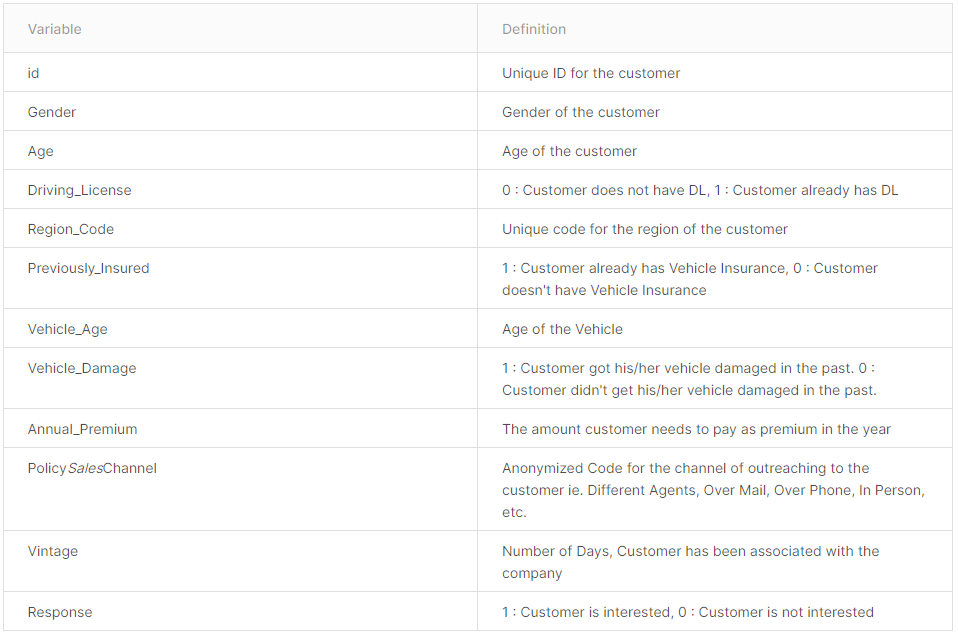

In [207]:
# Variable Definition

Image('../image/data_description.png')

### 1.1 Data Dimensions

In [209]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:381109
Number of Columns:12


### 1.2 Data Types

In [210]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

### 1.3 Check and Fillout NA

In [211]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

### 1.4 Change Types

### 1.5 Data Descriptive

##### 1.5.0 Defining Datasets

In [212]:
num_attributes = df1[['annual_premium', 'vintage', 'age']]
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

##### 1.5.1 Numerical Atributes

In [213]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
1,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688
2,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655


##### 1.5.1 Categorical Atributes

<AxesSubplot:xlabel='response', ylabel='id'>

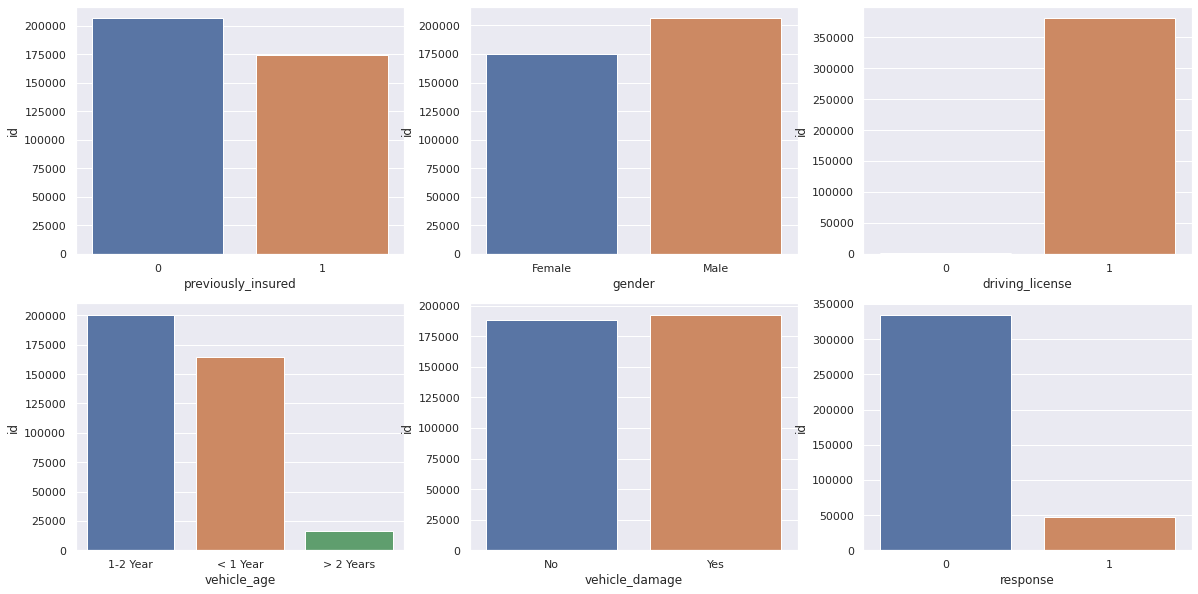

In [214]:
sns.set(rc={'figure.figsize':(20,10)})

plt.subplot(2,3,1)
aux1 = df1[['id', 'previously_insured']].groupby(['previously_insured']).count().reset_index()
sns.barplot(x='previously_insured', y='id', data=aux1)

plt.subplot(2,3,2)
aux1 = df1[['id', 'gender']].groupby(['gender']).count().reset_index()
sns.barplot(x='gender', y='id', data=aux1)

plt.subplot(2,3,3)
aux1 = df1[['id', 'driving_license']].groupby(['driving_license']).count().reset_index()
sns.barplot(x='driving_license', y='id', data=aux1)

plt.subplot(2,3,4)
aux1 = df1[['id', 'vehicle_age']].groupby(['vehicle_age']).count().reset_index()
sns.barplot(x='vehicle_age', y='id', data=aux1)

plt.subplot(2,3,5)
aux1 = df1[['id', 'vehicle_damage']].groupby(['vehicle_damage']).count().reset_index()
sns.barplot(x='vehicle_damage', y='id', data=aux1)

plt.subplot(2,3,6)
aux1 = df1[['id', 'response']].groupby(['response']).count().reset_index()
sns.barplot(x='response', y='id', data=aux1)

# 2. Feature Engineering

### 2.1 Mind Map

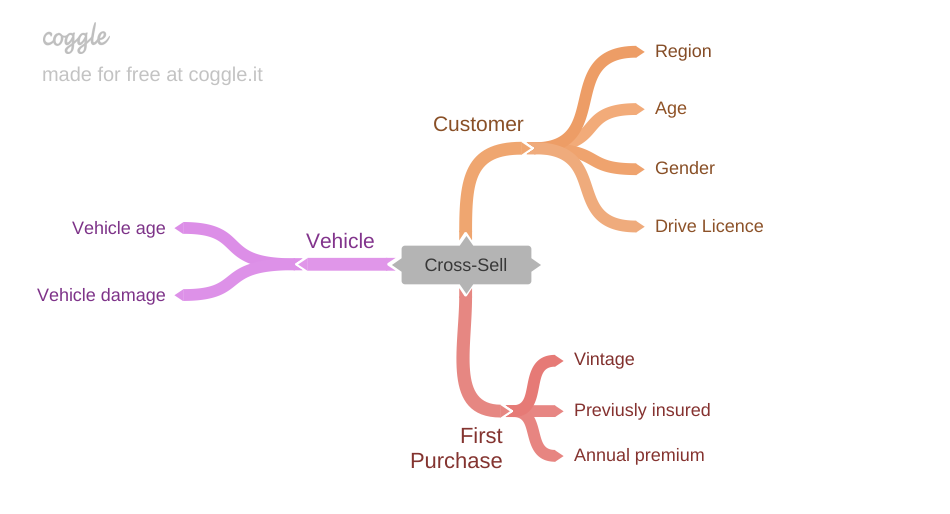

In [215]:
Image('../image/mind_map.png')

### 2.2 Hypothesis Definition

##### 2.2.1 Customer

- H1: Younger drivers are more likely to buy vehicle insurance
- H2: Women are more likely to buy vehicle insurance
- H3: Younger women are more likely to buy
- H4: Customers with driving licence are more likely to buy vehicle insurance

##### 2.2.2 First Purchase

- H5: Customers with more associate time are more likely to buy a vehicle insurance
- H6: Customers that already have vehicle insurance are more likely to buy.
- H7: Customers with the biggest annual premium are more likely to buy

##### 2.2.3 Vehicle

- H8: Customers with newer car are more likely to buy
- H9: Customers that already have vehicle damage are more likely to buy

### 2.3 Feature Engineering

In [216]:
# DF to Modelling
df = df1.copy()

# vehicle age
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

# vehicle damage
df['vehicle_damage'] = df['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [217]:
# DF to EDA
df2 = df1.copy()

In [218]:
# Categorical Features
df2['previously_insured'] = df2['previously_insured'].apply(lambda x: 'yes' if x==1 else 'no')
df2['driving_license'] = df2['driving_license'].apply(lambda x: 'yes' if x==1 else 'no')

In [219]:
# Vintage Month
df2['vintage_month'] = df2['vintage'] / 30
df2['vintage_month'] = df2['vintage_month'].astype(int)

# Age group
for i in range(len(df2)):
    if df2.loc[i, 'age'] < 35:
        df2.loc[i, 'age_group'] = 'young'
    elif df2.loc[i, 'age'] <55:
        df2.loc[i, 'age_group'] = 'adults'
    else:
        df2.loc[i, 'age_group'] = 'seniors'


# Vintage quarter group
for i in range(len(df2)):
    if df2.loc[i, 'vintage_month'] < 3:
        df2.loc[i, 'vintage_group'] = 't1'
    elif df2.loc[i, 'vintage_month'] <6:
        df2.loc[i, 'vintage_group'] = 't2'
    elif df2.loc[i, 'vintage_month'] <9:
        df2.loc[i, 'vintage_group'] = 't3'
    else:
        df2.loc[i, 'vintage_group'] = 't4'

# Premium Group
for i in range(len(df2)):
    if df2.loc[i, 'annual_premium'] < 30000:
        df2.loc[i, 'premium_group'] = 'small'
    elif df2.loc[i, 'annual_premium'] <50000:
        df2.loc[i, 'premium_group'] = 'medium'
    elif df2.loc[i, 'annual_premium'] <100000:
        df2.loc[i, 'premium_group'] = 'large'
    else:
        df2.loc[i, 'premium_group'] = 'extra_large'


# 3. Data Filtering

In [220]:
df3 = df2.copy()

# 4. Exploratory Data Analysis

### 4.1 Univariate Analysis

In [221]:
df4 = df3.copy()

<AxesSubplot:xlabel='age', ylabel='Count'>

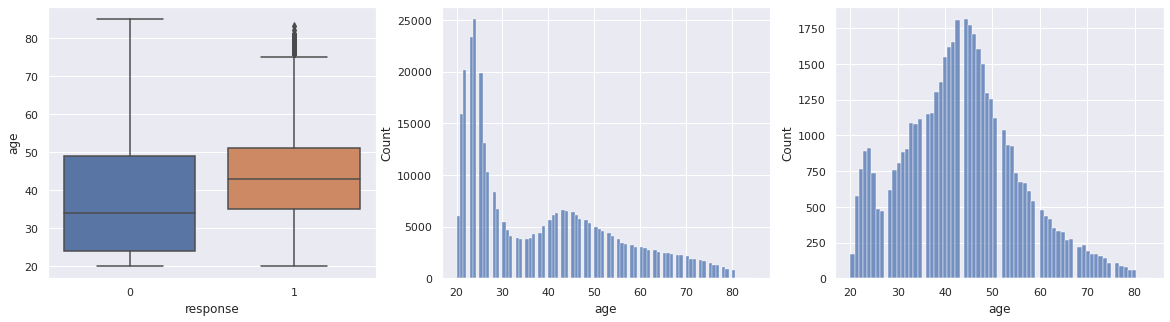

In [222]:
# age (indica ser uma boa variavel para classiciar os clientes)

sns.set(rc={'figure.figsize':(20,5)})

plt.subplot(1,3,1)
sns.boxplot(x='response', y='age', data=df4)

plt.subplot(1,3,2)
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(1,3,3)
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

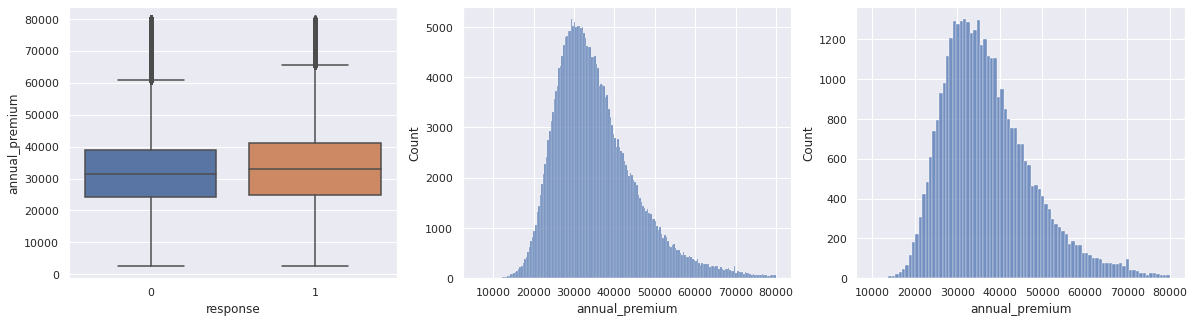

In [223]:
# annual premium (distribuições muito parecidas, ou seja, não é uma boa variável para classificar o grupo)

sns.set(rc={'figure.figsize':(20,5)})

plt.subplot(1,3,1)
aux = df4[df4['annual_premium']<80000] # --> medianas muito próximas, reduzi o range para poder vizualizar melhor a distribuição sem os outliers
sns.boxplot(x='response', y='annual_premium', data=aux)

plt.subplot(1,3,2)
aux = df4[(df4['annual_premium']>5000)&(df4['annual_premium']<80000)]   # --> distruibuição muito concentrada em valores pequenos, por isso o filtro
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(1,3,3)
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

In [226]:
df4.head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,response,vintage_month,age_group,vintage_group,premium_group
0,7,no,23367.0,249,Male,23,11.0,152.0,yes,< 1 Year,Yes,0,8,young,t3,small
1,13,yes,31409.0,221,Female,41,15.0,14.0,yes,1-2 Year,No,0,7,adults,t3,medium
2,18,yes,46622.0,299,Female,25,35.0,152.0,yes,< 1 Year,No,0,9,young,t4,medium
3,31,no,2630.0,136,Female,26,8.0,160.0,yes,< 1 Year,No,0,4,young,t2,small
4,39,no,42297.0,264,Male,45,8.0,124.0,yes,1-2 Year,Yes,0,8,adults,t3,medium


,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


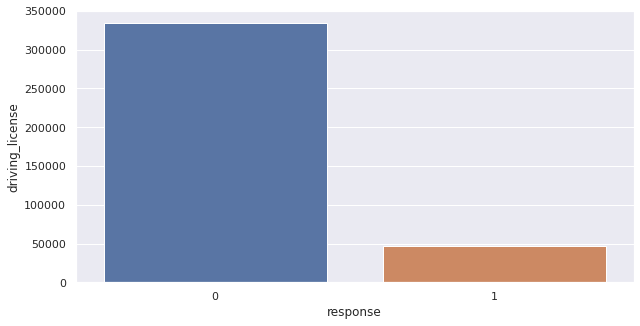

In [227]:
# driving license

sns.set(rc={'figure.figsize':(10,5)})
aux = df[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data = aux)

aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()

aux

<AxesSubplot:xlabel='region_code', ylabel='id'>

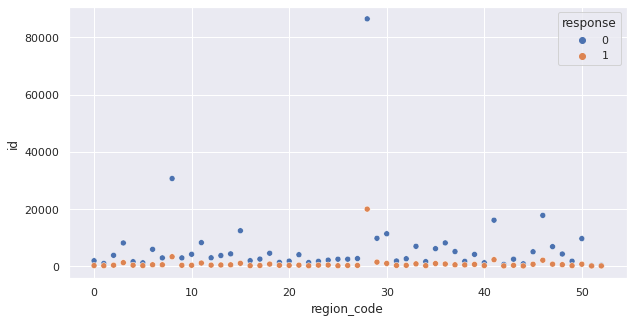

In [228]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

In [229]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
no,0.774546,0.225454
yes,0.999095,0.000905


In [230]:
# vehicle age
df4[['vehicle_age', 'response']].value_counts(normalize = True).reset_index()

,vehicle_age,response,0
0,1-2 Year,0,0.434285
1,< 1 Year,0,0.413488
2,1-2 Year,1,0.091328
3,> 2 Years,0,0.029663
4,< 1 Year,1,0.018897
5,> 2 Years,1,0.012338


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

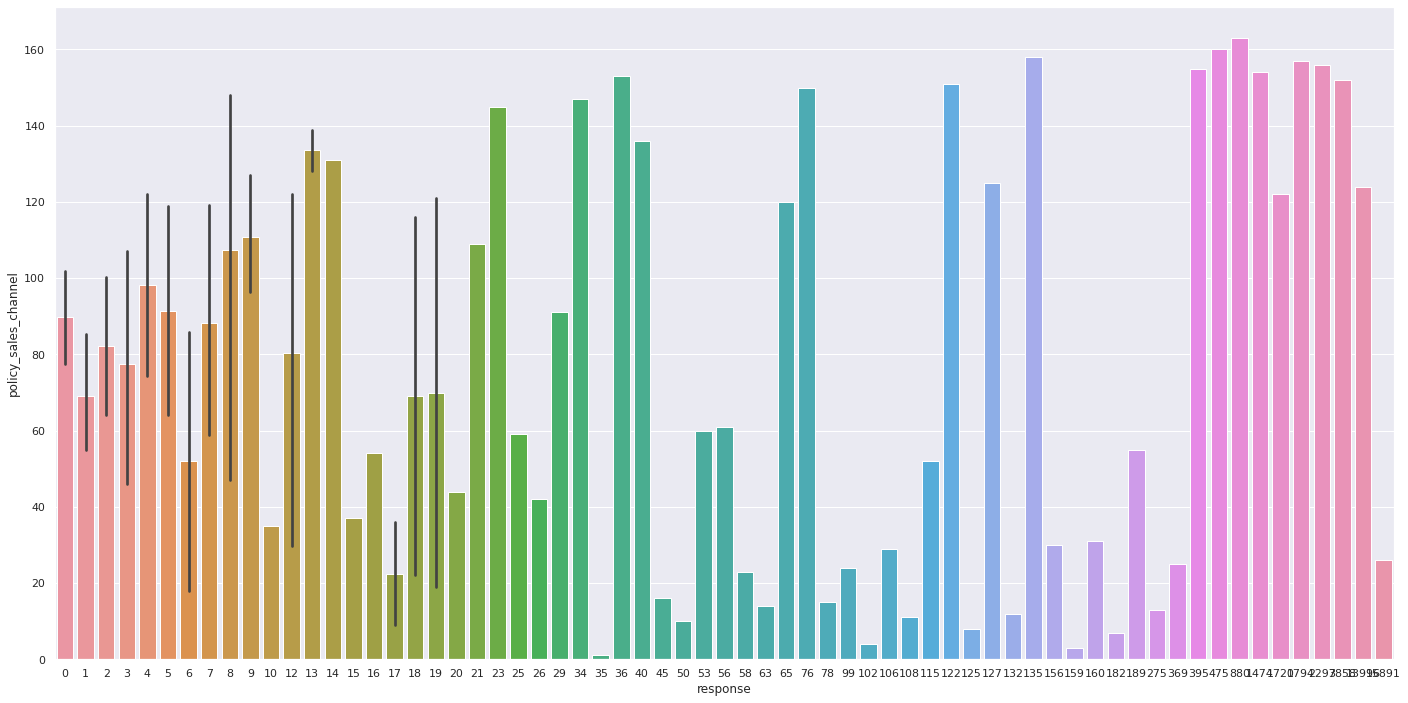

In [231]:
# policy sales channel --> buscar o grafico correto no discord


aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

plt.figure(figsize=(24,12))
sns.barplot(x = 'response', y = 'policy_sales_channel', data = aux)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

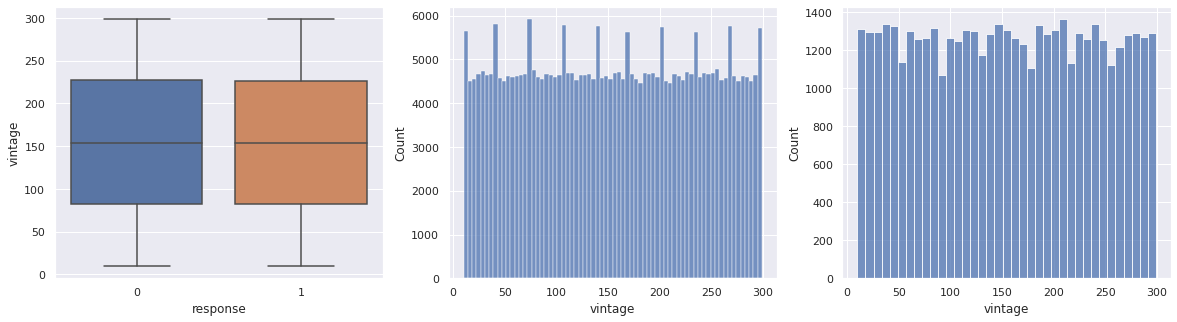

In [232]:
# vintage

sns.set(rc={'figure.figsize':(20,5)})

plt.subplot(1,3,1)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(1,3,2)
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux0)

plt.subplot(1,3,3)
aux1 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux1)

### 4.2 Bivariate Analysis

- H1: Younger drivers are more likely to buy vehicle insurance
- H2: Women are more likely to buy vehicle insurance
- H3: Customers with drive licence are more likely to buy vehicle insurance
- H4: Customers with more associate time are more likely to buy a vehicle insurance
- H5: Customers that already have vehicle insurance are more likely to buy.
- H6: Customers with the biggest annual premium are more likely to buy
- H7: Customers with newer car are more likely to buy
- H8: Customers that already have vehicle damage are more likely to buy

##### H1: Younger drivers are more likely to buy vehicle insurance

**False:** 6,1% of the young group are likely to buy, while 20,9% of the adults group and 11,8% of the seniors group are likely to buy.

In [233]:
df4['response'].value_counts()

0    334399
1     46710
Name: response, dtype: int64

,age_group,response,id,rate
1,adults,1,27691,20.895398
3,seniors,1,7886,11.821139
5,young,1,11133,6.121203


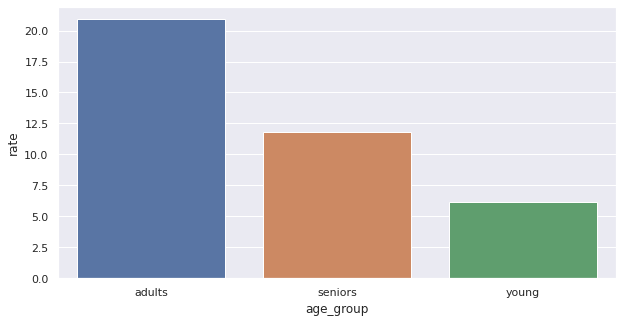

In [234]:
aux1 = df4[['id', 'response', 'age_group']].groupby(['age_group', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['age_group'] == aux1.loc[i, 'age_group'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='age_group', y='rate', data=aux1)

aux1

##### H2: Women are more likely to buy vehicle insurance

**False:** 10,4% of the female group are likely to buy, while 13,8% of male group are likely to buy.

,gender,response,id,rate
1,Female,1,18185,10.390241
3,Male,1,28525,13.841107


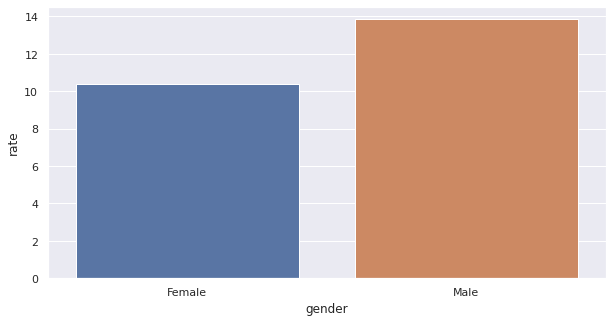

In [235]:
aux1 = df4[['id', 'response', 'gender']].groupby(['gender', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['gender'] == aux1.loc[i, 'gender'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='gender', y='rate', data=aux1)

aux1

##### H3: Customers with driving licence are more likely to buy vehicle insurance

**True:** 12,2% of customers that have driving licence are likely to buy, while 5% of customers that don't have are likely to buy.

,driving_license,response,id,rate
1,no,1,41,5.049261
3,yes,1,46669,12.271724


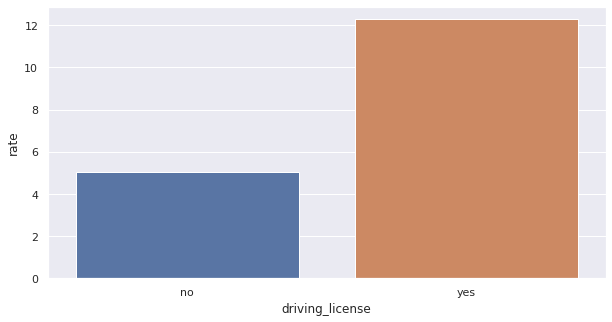

In [236]:
aux1 = df4[['id', 'response', 'driving_license']].groupby(['driving_license', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['driving_license'] == aux1.loc[i, 'driving_license'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='driving_license', y='rate', data=aux1)

aux1

##### H4: Customers with more associate time (vintage) are more likely to buy a vehicle insurance

**False:** It doesn't matter the associate time, every vintage group has the same rate to buy a vehicle insurance.

,vintage_group,response,id,rate
1,t1,1,12975,12.321469
3,t2,1,14402,12.170841
5,t3,1,14531,12.28484
7,t4,1,4802,12.253438


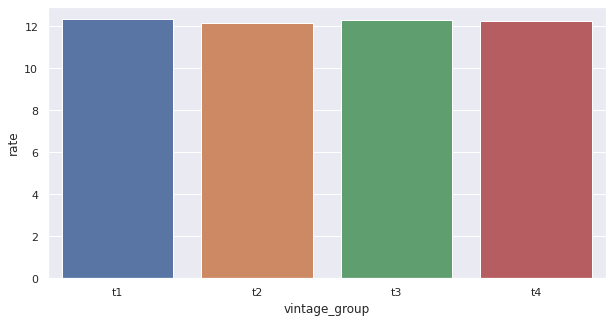

In [237]:
aux1 = df4[['id', 'response', 'vintage_group']].groupby(['vintage_group', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['vintage_group'] == aux1.loc[i, 'vintage_group'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='vintage_group', y='rate', data=aux1)

aux1

##### H5: Customers that don't have vehicle insurance are more likely to buy.

**True:** Those who don't are previously insured are more likely to buy a vehicle insurance.

,previously_insured,response,id,rate
1,no,1,46552,22.545416
3,yes,1,158,0.090478


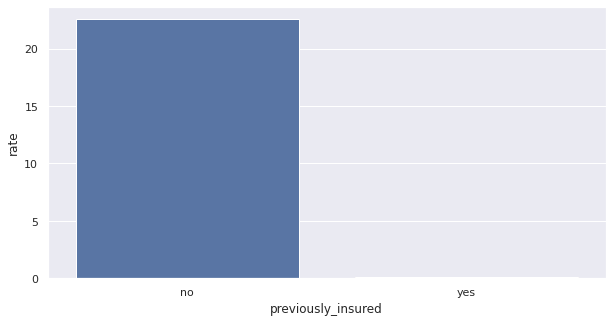

In [238]:
aux1 = df4[['id', 'response', 'previously_insured']].groupby(['previously_insured', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['previously_insured'] == aux1.loc[i, 'previously_insured'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='previously_insured', y='rate', data=aux1)

aux1

##### H6: Customers with the biggest annual premium are more likely to buy.

**True:** Those who annual premium are over 50k dolars are more likely to buy a vehicle insurance.

,premium_group,response,id,rate
1,extra_large,1,123,15.809769
3,large,1,4776,15.195189
5,medium,1,23277,12.731151
7,small,1,18534,11.16069


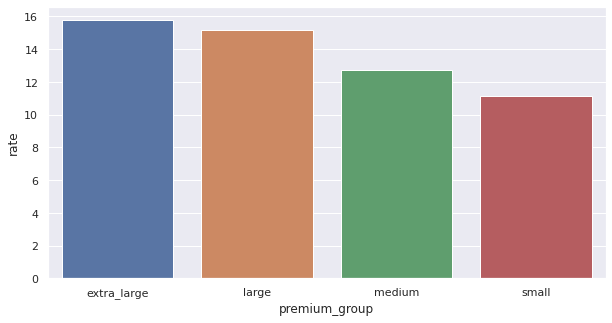

In [239]:
aux1 = df4[['id', 'response', 'premium_group']].groupby(['premium_group', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['premium_group'] == aux1.loc[i, 'premium_group'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='premium_group', y='rate', data=aux1)

aux1

##### H7: Customers with newer car are more likely to buy.

**False:** How older the vehicle, the more likely to buy the customer.

,vehicle_age,response,id,rate
1,1-2 Year,1,34806,17.375547
3,< 1 Year,1,7202,4.370517
5,> 2 Years,1,4702,29.374649


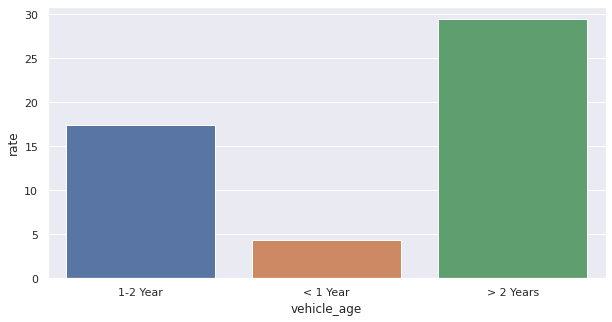

In [240]:
aux1 = df4[['id', 'response', 'vehicle_age']].groupby(['vehicle_age', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['vehicle_age'] == aux1.loc[i, 'vehicle_age'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='vehicle_age', y='rate', data=aux1)

aux1

##### H8: Customers that already had vehicle damage are more likely to buy.

**True:** Those who already had vehicle damage are more likely to buy.

,vehicle_damage,response,id,rate
1,No,1,982,0.520414
3,Yes,1,45728,23.765546


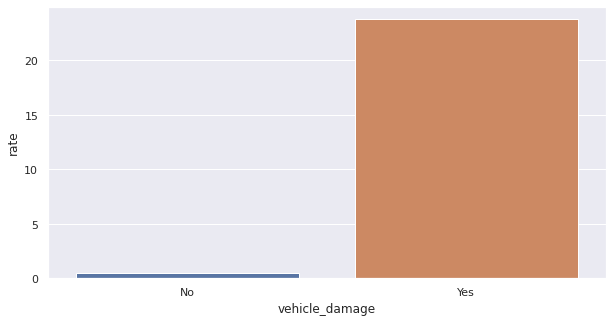

In [241]:
aux1 = df4[['id', 'response', 'vehicle_damage']].groupby(['vehicle_damage', 'response']).count().reset_index()

aux1['rate'] = ''

for i in range(len(aux1)):
    aux1.loc[i, 'rate'] = (aux1.loc[i, 'id']) / (aux1['id'][(aux1['vehicle_damage'] == aux1.loc[i, 'vehicle_damage'])].sum()) *100

aux1 = aux1[aux1['response'] == 1]

sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x='vehicle_damage', y='rate', data=aux1)

aux1

### 4.3 Multivariate Analysis

##### 4.3.1 Numerical Attributes

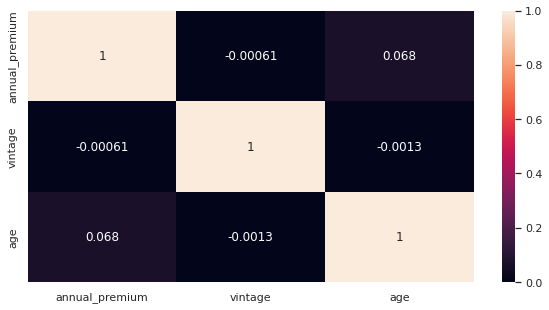

In [242]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation , annot = True);

##### 4.3.1 Categorical Attributes

In [243]:
# Only categorical data:
a = df4[['previously_insured', 'gender', 'vehicle_age', 'vehicle_damage']]

a.head()

,previously_insured,gender,vehicle_age,vehicle_damage
0,no,Male,< 1 Year,Yes
1,yes,Female,1-2 Year,No
2,yes,Female,< 1 Year,No
3,no,Female,< 1 Year,No
4,no,Male,1-2 Year,Yes


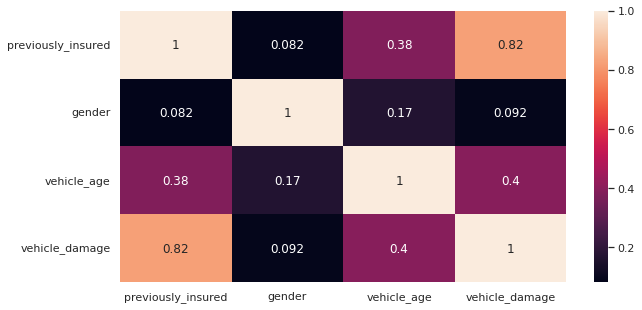

In [244]:
# Calculate Cramér's V:
a1 = cramer_v(a['previously_insured'], a['previously_insured'])
a2 = cramer_v(a['previously_insured'], a['gender'])
a3 = cramer_v(a['previously_insured'], a['vehicle_age'])
a4 = cramer_v(a['previously_insured'], a['vehicle_damage'])

a5 = cramer_v(a['gender'], a['previously_insured'])
a6 = cramer_v(a['gender'], a['gender'])
a7 = cramer_v(a['gender'], a['vehicle_age'])
a8 = cramer_v(a['gender'], a['vehicle_damage'])

a9  = cramer_v(a['vehicle_age'], a['previously_insured'])
a10 = cramer_v(a['vehicle_age'], a['gender'])
a11 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a12 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a13 = cramer_v(a['vehicle_damage'], a['previously_insured'])
a14 = cramer_v(a['vehicle_damage'], a['gender'])
a15 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a16 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

d = pd.DataFrame({'previously_insured':   [a1, a2, a3, a4],
                  'gender':               [a5, a6, a7, a8],
                  'vehicle_age':          [a9, a10, a11, a12],
                  'vehicle_damage':       [a13, a14, a15, a16]})

d = d.set_index(d.columns)

sns.heatmap (d, annot = True);

# 5. Data Preparation

### 5.0 Split Dataset

In [246]:
df5 = df.copy()

In [247]:
X = df5.drop('response', axis = 1)
Y = df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, Y, test_size = 0.20)

df5 = pd.concat([x_train, y_train], axis=1)

### 5.1 Standardization

In [248]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../parameter/annual_premium_scaler.pkl', 'wb'))

# Obs.:
# df5['annual_premium']             --> retorna uma série
# df5[['annual_premium']]           --> retorna uma coluna
# df5[['annual_premium']].values    --> retorna um array

### 5.2 Rescaling

In [249]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age 
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../parameter/age_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../parameter/vintage_scaler.pkl', 'wb'))

### 5.3 Encoder

In [250]:
# driving_license       - Label encoding (already done)
# previously_insured    - Label encoding (already done)
# vehicle_damage        - Label encoding (already done)

# gender - Onde Hot Encoding or **Target Encoding**
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../parameter/target_encode_gender_scaler.pkl', 'wb'))

# region_code - Frequency Encoding or **Target Encoding**
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[: , 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../parameter/target_encode_region_code_scaler.pkl', 'wb'))

# vehicle_age - **One Hot Encoding** or Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / **Frequency Encoding**
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[: , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../parameter/fe_policy_sales_channel_scaler.pkl', 'wb'))

### 5.4 Validation Preparation

In [251]:
# # gender
# x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# # age
# x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# # region code
# x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# # vehicle age
# # x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# # annual_premium
# x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# # policy sales channel
# x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# # vintage
# x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# # fillna (tem regiões nos dados de teste que não estão nos dados de treino)
# x_validation = x_validation.fillna(0)

# 6. Feature Selection

In [252]:
df6 = df5.copy()

In [253]:
df6.head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
210735,158506,1,-0.402760,0.159170,0.138452,0.123077,0.068591,0.353341,1,0,0,1,0,0
135524,320899,0,0.041284,0.449827,0.104015,0.046154,0.081533,0.353341,1,1,0,1,0,0
256429,143803,0,-0.015988,0.058824,0.138452,0.076923,0.071327,0.353341,1,0,0,1,0,0
138679,346421,1,-1.623546,0.117647,0.104015,0.046154,0.121734,0.353341,1,0,0,1,0,0
322058,287203,0,0.466082,0.730104,0.138452,0.000000,0.064387,0.057323,1,1,0,1,0,0


In [267]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [289]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# Feature ranking
# print('Feature Ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'Feature': i, 'Importance': j}, index=[0])
    df = pd.concat([df, aux], axis = 0)

df = df.sort_values('Importance', ascending=False)
df

,Feature,Importance
0,vintage,0.273050
0,annual_premium,0.244847
0,age,0.164564
0,region_code,0.105312
0,vehicle_damage,0.072926
0,policy_sales_channel,0.060440
0,previously_insured,0.049663
0,vehicle_age_below_1_year,0.014791
0,vehicle_age_between_1_2_year,0.006565
0,gender,0.005231


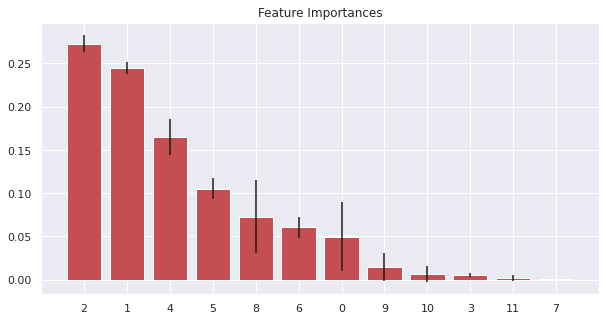

In [287]:
# Plot the importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

In [256]:
cols_selected = ['annual_premium',
                 'vintage',
                 'age',
                 'region_code',
                 'vehicle_damage',
                 'previously_insured',
                 'policy_sales_channel']

# 7. Machine Learning

### 7.0 Dataset

In [257]:
df7 = df6.copy()

x_train = df7[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

### 7.1 KNN

,Precision_at_k,Recall_at_k
KNN,0.124,0.266


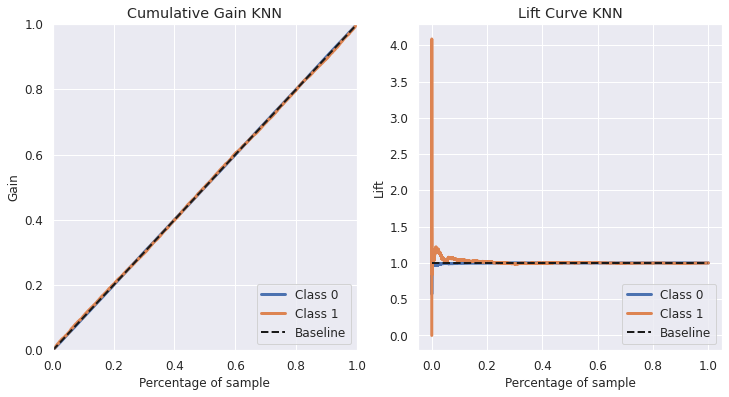

In [258]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_val)

# Culative Gain and Lift Curve 
fig, axs = plt.subplots(ncols=2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axs[0], title='Cumulative Gain KNN')
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=axs[1], title='Lift Curve KNN')

# Metrics
knn_result = at_k_metrics( 'KNN', x_validation, y_validation, yhat_knn, k=20000 )
knn_result

### 7.2 Logistic Regression

,Precision_at_k,Recall_at_k
LR,0.123,0.265


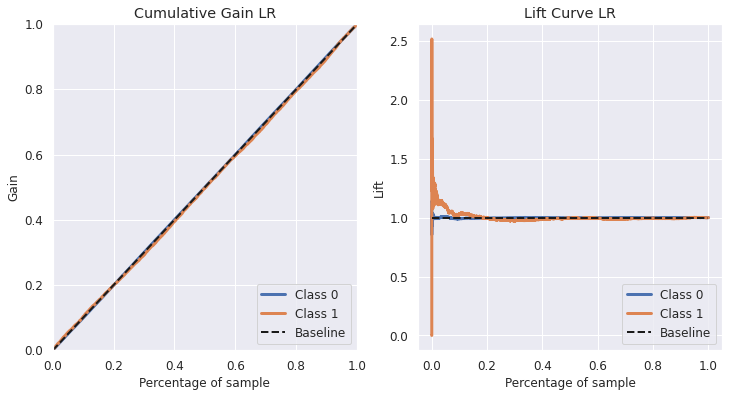

In [259]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# Culative Gain and Lift Curve 
fig, axs = plt.subplots(ncols=2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axs[0], title='Cumulative Gain LR')
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=axs[1], title='Lift Curve LR')

# Metrics
lr_result = at_k_metrics( 'LR', x_validation, y_validation, yhat_lr, k=20000 )
lr_result

### 7.3 Extra Trees

,Precision_at_k,Recall_at_k
ET,0.253,0.542


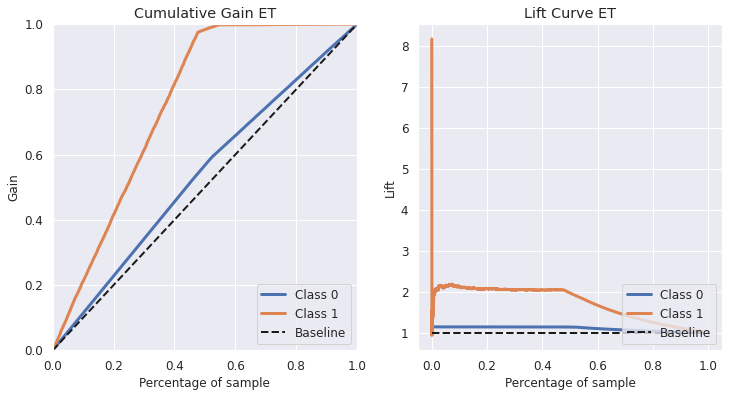

In [260]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state = 42)

# model training
et_model.fit(x_train, y_train)

# model prediction - poder de generalização
yhat_et = et_model.predict_proba(x_val)

# Culative Gain and Lift Curve 
fig, axs = plt.subplots(ncols=2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax=axs[0], title='Cumulative Gain ET')
skplt.metrics.plot_lift_curve(y_val, yhat_et, ax=axs[1], title='Lift Curve ET')

# Metrics
et_result = at_k_metrics( 'ET', x_validation, y_validation, yhat_et, k=20000 )
et_result

### 7.4 Random Forest

,Precision_at_k,Recall_at_k
RF,0.253,0.542


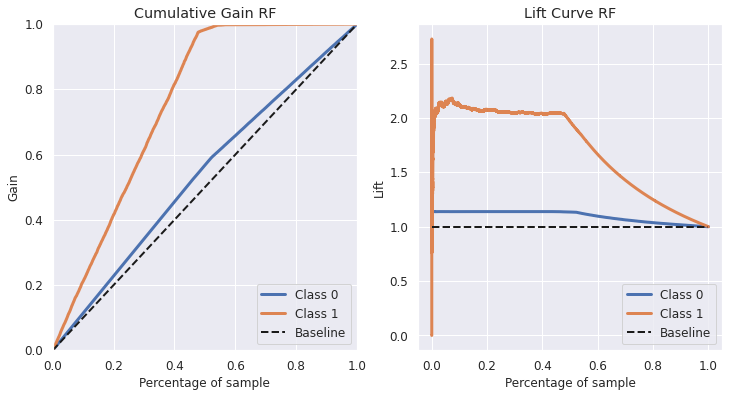

In [261]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state = 42)

# model training
rf_model.fit(x_train, y_train)

# model prediction - poder de generalização
yhat_rf = rf_model.predict_proba(x_val)

# Culative Gain and Lift Curve 
fig, axs = plt.subplots(ncols=2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax=axs[0], title='Cumulative Gain RF')
skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax=axs[1], title='Lift Curve RF')

# Metrics
rf_result = at_k_metrics( 'RF', x_validation, y_validation, yhat_rf, k=20000 )
rf_result


### 7.5 Light Gradient Boosting Machine Classifier Model

,Precision_at_k,Recall_at_k
LGBM,0.253,0.543


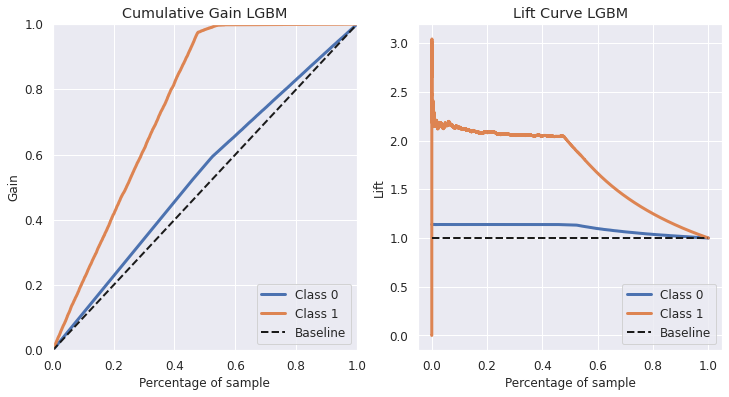

In [262]:
# model definition
lgbm_model = LGBMClassifier()

# model training
lgbm_model.fit(x_train, y_train)

# model prediction - poder de generalização
yhat_lgbm = lgbm_model.predict_proba(x_val)

# Culative Gain and Lift Curve 
fig, axs = plt.subplots(ncols=2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm, ax=axs[0], title='Cumulative Gain LGBM')
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm, ax=axs[1], title='Lift Curve LGBM')

# Metrics
lgbm_result = at_k_metrics( 'LGBM', x_validation, y_validation, yhat_lgbm, k=20000 )
lgbm_result

### 7.6 Model Performance Comparison

##### 7.6.1 Single Performance

In [263]:
modelling_result = pd.concat ([knn_result, lr_result, et_result, rf_result, lgbm_result])
modelling_result.sort_values('Recall_at_k')

,Precision_at_k,Recall_at_k
LR,0.123,0.265
KNN,0.124,0.266
ET,0.253,0.542
RF,0.253,0.542
LGBM,0.253,0.543


##### 7.6.1 Cross Validation

In [265]:
knn_cv = cross_validation('KNN', knn_model, x_train, y_train)
lr_cv = cross_validation('LR', lr_model, x_train, y_train)
et_cv = cross_validation('ET', et_model, x_train, y_train)
rf_cv = cross_validation('RF', rf_model, x_train, y_train)
lgbm_cv = cross_validation('LGBM', lgbm_model, x_train, y_train)

In [266]:
modelling_result_cv = pd.concat ([knn_cv, lr_cv, et_cv, rf_cv, lgbm_cv])
modelling_result_cv.sort_values('CV_Recall_at_k')

,CV_Precision_at_k,CV_Recall_at_k
KNN,0.28 +/- 0.0,0.74 +/- 0.0
LR,0.28 +/- 0.0,0.74 +/- 0.0
ET,0.29 +/- 0.0,0.77 +/- 0.0
RF,0.29 +/- 0.0,0.78 +/- 0.0
LGBM,0.31 +/- 0.0,0.83 +/- 0.0


# 8 Hyperparameter Fine Tunning

# 9. Deploy to Production

### 9.0 Save Trained Model

In [ ]:
pickle.dump(lr_model, open ('../model/logistic_regression.pkl', 'wb'))
pickle.dump(knn_model, open ('../model/knn_model.pkl', 'wb'))
pickle.dump(lgbm_model, open ('../model/lgbm_model.pkl', 'wb'))

### 9.1 Health Insurance Class

In [ ]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:
    def __init__(self):
        self.home_path = '/home/vitor/Repos/cross_sell_project/cross-sell/'
        self.annual_premium_scaler              = pickle.load(open(self.home_path + 'parameter/annual_premium_scaler.pkl'))
        self.age_scaler                         = pickle.load(open(self.home_path + 'parameter/age_scaler.pkl'))
        self.vintage_scaler                     = pickle.load(open(self.home_path + 'parameter/vintage_scaler.pkl'))
        self.target_encode_gender_scaler        = pickle.load(open(self.home_path + 'parameter/target_encode_gender_scaler.pkl'))
        self.target_encode_region_code_scaler   = pickle.load(open(self.home_path + 'parameter/target_encode_region_code_scaler.pkl'))
        self.fe_policy_sales_channel_scaler     = pickle.load(open(self.home_path + 'parameter/fe_policy_sales_channel_scaler.pkl'))

    def data_cleaning(df1):
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 
        'vehicle_age', 'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        df1.columns = cols_new

        return df1
   
   
    def feature_engineering(df0):

        # vehicle age
        df0['vehicle_age'] = df0['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

        # vehicle damage
        df0['vehicle_damage'] = df0['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)   

        return df0

    def data_preparation (self, df5):
 
        # annual_premium - standart
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # age - MinMaxScaler
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # gender - Target Encoding
        df5.loc[:,'gender'] = df5['gender'].map(self.target_encode_gender_scaler)

        # region_code - Target Encoding
        df5.loc[: , 'region_code'] = df5['region_code'].map(self.target_encode_region_code_scaler)

        # vehicle_age - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel - Frequency Encoding
        df5.loc[: , 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        # feature selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']
        
        return df5[cols_selected]
    
    def get_prediction (self, model, original_data, test_data):
        # model prediction
        pred = model.predict_proba(test_data)

        # join prediction into original data
        original_data['score'] = pred
        
        return original_data.to_json(orient='records', data_format='iso')    
    

### 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from HealthInsurance import HealthInsurance

# loading model
path = '/home/vitor/Repos/cross_sell_project/cross-sell/'
model = pickle.load(open(path + 'model/logistic_regression.pkl', 'rb'))

# initialize API
app = Flask(__name__)
@app.route('/predict', methods=['POST'])    #OBS1: metodo POST significa que a api só pode receber requisições, não pode fazer gets.
                                            #OBS2: quando a API recebe uma requisição no end point '/predict' ela roda a função abaixo.

def health_insurance_predict():
    test_json = request.get_json()          #OBS3: quarda o json que a função recebeu pela requisição e salva na variável test_json.

    if test_json:                                                                       #OBS1: se realmente foi passado um dado
            if isinstance(test_json, dict):                                             #OBS2: testar se é um dicionário (dic só tem uma linha - unique example)
                test_raw = pd.DataFrame(test_json, index=[0])
            
            else:                                                                       #OBS3: multiple example (várias linhas)
                test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())         #OBS4: o nome das colunas serão as chaves dos jsons


            # Instantiate the HI Class
            pipeline = HealthInsurance()

            # Data Cleaning
            df1 = pipeline.data_cleaning(test_raw)

            # Feature Engineering
            df2 = pipeline.feature_engineering(df1)

            # Data Preparation
            df3 = pipeline.data_preparation(df2)

            # Prediction
            df_response = pipeline.get_prediction(model, test_raw, df3)
            
            return df_response

    else:
        return Response ('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

ModuleNotFoundError: No module named 'HealthInsurance'

### 9.3 API Tester

In [ ]:
# fillna (tem regiões nos dados de teste que não estão nos dados de treino)
x_validation = x_validation.fillna(0)

# loading test dataset
df_test = x_validation

# df_test['response'] = y_validation

In [ ]:
df_test = df_test.sample(20)

In [ ]:
df_test

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
81800,271645,1,23792.0,118,Female,27,33.0,124.0,1,below_1_year,0
146608,29386,0,52119.0,129,Male,59,28.0,56.0,1,below_1_year,0
303137,135852,0,33528.0,107,Male,39,8.0,124.0,1,below_1_year,0
232598,332979,1,20347.0,83,Male,45,13.0,24.0,1,below_1_year,0
361886,227903,1,42384.0,166,Female,23,28.0,152.0,1,below_1_year,0
33106,264314,1,16958.0,16,Male,71,46.0,30.0,1,below_1_year,0
171355,226352,1,21680.0,245,Female,28,41.0,152.0,1,below_1_year,0
88278,323495,0,2630.0,137,Female,47,28.0,26.0,1,below_1_year,0
9029,72387,1,31544.0,285,Male,63,28.0,26.0,1,below_1_year,0
23333,186426,0,30233.0,244,Male,48,2.0,61.0,1,below_1_year,0


In [ ]:
# Convert dataframe to json

data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API Call

# url = 'http://0.0.0.0:5000/predict'

url = 'https://insurance-all-vhmf.herokuapp.com/predict' 
     # https://insurance-all-vhmf.herokuapp.com/predict

header = {'Content-type': 'application/json'}                  

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending=False).head()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,score
7,145509,0,1.023666,0.363322,0.103776,0.338462,0.187949,122.0,1,below_1_year,0,0.056403
15,128839,0,0.446360,0.162630,0.137857,0.523077,0.187949,157.0,1,below_1_year,0,0.055049
18,20721,0,1.303818,0.242215,0.137857,0.415385,0.187949,26.0,1,below_1_year,0,0.048765
4,339125,0,-0.378198,0.519031,0.137857,0.492308,0.187949,26.0,1,below_1_year,0,0.047494
16,218027,0,0.371998,0.498270,0.137857,0.569231,0.120308,124.0,1,below_1_year,0,0.035503
